In [15]:
import fiona
import numpy as np
import pandas as pd
from panel import Panel
from rendering import *

%load_ext autoreload
%autoreload 2

set_up()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
filename = 'qgis_assets/modulos_automatico_final_new.shp'
shp = fiona.open(filename)
print(shp.schema)

{'properties': {'No.': 'int:10', 'Area (Ha)': 'float:11.2', 'Perimetro(': 'float:11.2', 'Area(m2)': 'float:11.2', 'Perimetr_1': 'float:11.2', 'ID_ARRAY': 'int:18', 'ID_CELL': 'int:18', 'ID_ROW': 'int:18', 'ID_COL': 'int:18'}, 'geometry': 'Polygon'}


In [17]:
def get_array_size(id_array, panel_indices, panel_buffer, norm_x):
    # Calculate bounding box of array
    min_x, max_x, min_y, max_y = 2e32, -2e32, 2e32, -2e32

    for idx in panel_indices:
        for coord in panels[idx].geometry:
            # Rotate geometry according to norm_x
            rotated_geometry = [coord[0] * norm_x[0] + coord[1] * norm_x[1], -coord[0] * norm_x[1] + coord[1] * norm_x[0]]
            if rotated_geometry[0] < min_x:
                min_x = rotated_geometry[0]
            if rotated_geometry[0] > max_x:
                max_x = rotated_geometry[0]
            if rotated_geometry[1] < min_y:
                min_y = rotated_geometry[1]
            if rotated_geometry[1] > max_y:
                max_y = rotated_geometry[1]

    return max_x - min_x, max_y - min_y, [min_x, min_y], [max_x, max_y]


def is_point_in_array(point, norm_x, array_min, array_max):
    rotated_point = [point[0] * norm_x[0] + point[1] * norm_x[1], -point[0] * norm_x[1] + point[1] * norm_x[0]]

    if array_min[0] < rotated_point[0] < array_max[0] and array_min[1] < rotated_point[1] < array_max[1]:
        return True
    else:
        return False

def get_panel_geometry(point, x, width, y, height):
    max_x_max_y = point + x * width / 2 + y * height / 2
    min_x_min_y = point - x * width / 2 - y * height / 2
    max_x_min_y = point + x * width / 2 - y * height / 2
    min_x_max_y = point - x * width / 2 + y * height / 2

    return [max_x_max_y, min_x_max_y, min_x_min_y, max_x_min_y]

In [18]:
def load_panels(shp):
    panels = []
    cluster = dict()

    for (idx, elem) in enumerate(shp):
        panel = Panel()
        panel.id_array = elem['properties']['ID_ARRAY']
        panel.id_panel = elem['properties']['ID_CELL']
        panel.row = elem['properties']['ID_ROW']
        panel.col = elem['properties']['ID_COL']
        panel.geometry = elem['geometry']['coordinates'][0]
        panel.compute_centroid()

        # Plot geometry
        # fig, ax = plt.subplots()
        # x = []
        # y = []
        # for (idx, coord) in enumerate(panel.geometry):
        #     x.append(coord[0])
        #     y.append(coord[1])
        #
        #     if idx >= 4:
        #         break
        # ax.plot(x, y, color='black')
        # plt.show()

        panels.append(panel)
        if panel.id_array not in cluster:
            cluster[panel.id_array] = []
        cluster[panel.id_array].append(idx)

    plot_panels(panels, color_code=[panel.id_array for panel in panels], draw_text=False, text=[str(panel.id_array) for panel in panels], draw_legend=False, savefig='results/starting_panels.png', remove_axis=True, )

    return panels, cluster

In [19]:
def fill_panels(panels, cluster, threshold_distance=1.2):
    for key in cluster:
        row_panels = dict()

        for idx in cluster[key]:
            if panels[idx].row not in row_panels:
               row_panels[panels[idx].row] = []
            row_panels[panels[idx].row].append(idx)
            # Sort according to column
            row_panels[panels[idx].row].sort(key=lambda x: panels[x].col)

        # Grid size
        max_cols, max_rows = 0, len(row_panels)
        for row in row_panels:
            if len(row_panels[row]) > max_cols:
                max_cols = len(row_panels[row])

        # Average direction
        average_direction = np.zeros(2)
        num_panels = 0

        for row in row_panels:
            for idx in row_panels[row]:
                vec_x_1 = np.asarray(panels[idx].geometry[1]) - np.asarray(panels[idx].geometry[0])
                vec_x_2 = np.asarray(panels[idx].geometry[2]) - np.asarray(panels[idx].geometry[3])
                # Normalize
                norm_vec_x_1 = vec_x_1 / np.linalg.norm(vec_x_1)
                norm_vec_x_2 = vec_x_2 / np.linalg.norm(vec_x_2)

                average_direction = average_direction + norm_vec_x_1 + norm_vec_x_2
                num_panels += 2

        average_direction = average_direction / num_panels
        norm_x = average_direction / np.linalg.norm(average_direction)
        norm_y = np.asarray([-norm_x[1], norm_x[0]])

        # Size of array
        array_width, array_height, array_min, array_max = get_array_size(key, cluster[key], panels, norm_x)

        # Calculate average width and height of panels
        average_width = 0
        average_height = 0
        num_panels = 0

        for row in row_panels:
            for idx in row_panels[row]:
                average_width += np.linalg.norm(np.asarray(panels[idx].geometry[0]) - np.asarray(panels[idx].geometry[1]))
                average_width += np.linalg.norm(np.asarray(panels[idx].geometry[2]) - np.asarray(panels[idx].geometry[3]))
                average_height += np.linalg.norm(np.asarray(panels[idx].geometry[1]) - np.asarray(panels[idx].geometry[2]))
                average_height += np.linalg.norm(np.asarray(panels[idx].geometry[3]) - np.asarray(panels[idx].geometry[0]))
                num_panels += 2
        average_width /= num_panels
        average_height /= num_panels

        # average_distance_x = (array_width - average_width * max_cols) / (max_cols - 1)
        # average_distance_y = (array_height - average_height * max_rows) / (max_rows - 1)

        # Calculate average distance x and y in another way
        average_distance_x = 0
        num_panels_x = 0

        for row in row_panels:
            for idx in range(len(row_panels[row]) - 1):
                avg_distance = np.linalg.norm(np.asarray(panels[row_panels[row][idx]].centroid) - np.asarray(panels[row_panels[row][idx + 1]].centroid))
                if avg_distance < (average_width * 1.5):
                    average_distance_x += avg_distance
                    num_panels_x += 1

        average_distance_x = average_distance_x / num_panels_x - average_width
        expected_rows = array_height / (average_height + 1 / 10 * average_height)
        average_distance_y = (array_height - average_height * expected_rows) / (expected_rows - 1)
        max_cols = np.round((array_width - average_distance_x) / (average_width + average_distance_x))

        # Minimum point of array
        min_x, min_y = 2e32, 2e32
        for row in row_panels:
            for idx in row_panels[row]:
                if panels[idx].centroid[0] < min_x:
                    min_x = panels[idx].centroid[0]
                if panels[idx].centroid[1] < min_y:
                    min_y = panels[idx].centroid[1]

        # Sort row panels according to key
        row_panels = dict(sorted(row_panels.items(), key=lambda item: item[0]))

        for row in row_panels:
            if len(row_panels[row]) < max_cols:
                # starting_point = np.asarray([min_x + average_width / 2.0, min_y + average_height / 2.0 * row_idx + (average_distance_y * (row_idx - 1) if row_idx > 0 else 0)])
                num_panels = len(row_panels[row])
                new_panels = []

                # Missing panels - start from the left
                starting_point = panels[row_panels[row][0]].centroid - norm_x * (average_width + average_distance_x / 2.0) - norm_y * average_distance_y / 2.0
                print('Start', num_panels, max_cols)
                while is_point_in_array(starting_point, norm_x, array_min, array_max):
                    # Include new panel
                    new_panel = Panel()
                    new_panel.id_array = key
                    new_panel.row = row
                    new_panel.geometry = get_panel_geometry(starting_point, norm_x, average_width, norm_y, average_height)
                    new_panel.centroid = starting_point
                    panels.append(new_panel)
                    new_panels.append((len(panels) - 1))
                    num_panels += 1

                    row_panels[row].insert(0, len(panels) - 1)
                    starting_point = starting_point - norm_x * (average_width + average_distance_x)

                # Find missing panels in the middle
                i = 0

                print('Middle', num_panels, max_cols)
                while i < (num_panels - 1) and num_panels < max_cols:
                    # Calculate distance between adjacent panels
                    centroid1 = panels[row_panels[row][i]].centroid
                    centroid2 = panels[row_panels[row][i + 1]].centroid
                    distance = np.linalg.norm(centroid1 - centroid2)
                    print(distance / (average_width + average_distance_x), average_width, distance)

                    if distance > ((average_width + average_distance_x) * threshold_distance) and distance > average_width:
                        new_centroid = centroid1 + norm_x * (average_width + average_distance_x * 1.5) - norm_y * average_distance_y / 2.0
                        print(panels[row_panels[row][i]].col, panels[row_panels[row][i + 1]].col)
                        print(centroid1, centroid2, new_centroid, distance, average_width, average_distance_x)
                        new_panel = Panel()
                        new_panel.id_array = key
                        new_panel.row = row
                        new_panel.geometry = get_panel_geometry(new_centroid, norm_x, average_width, norm_y, average_height)
                        new_panel.centroid = new_centroid
                        panels.append(new_panel)
                        num_panels += 1

                        # Insert new panel in the list
                        row_panels[row].insert(i + 1, len(panels) - 1)

                    i += 1

                # Missing panels - start from the right
                starting_point = panels[row_panels[row][len(row_panels[row]) - 1]].centroid + norm_x * average_distance_x - norm_y * average_distance_y / 2.0
                print('End', num_panels, max_cols)
                while num_panels < max_cols:
                    starting_point = starting_point + norm_x * (average_width + average_distance_x)
                    # Include new panel
                    new_panel = Panel()
                    new_panel.id_array = key
                    new_panel.row = row
                    new_panel.geometry = get_panel_geometry(starting_point, norm_x, average_width, norm_y, average_height)
                    new_panel.centroid = starting_point
                    panels.append(new_panel)
                    new_panels.append(len(panels) - 1)
                    num_panels += 1

                # Append new panels to row
                row_panels[row].extend(new_panels)
                # Sort by centroid x
                row_panels[row] = sorted(row_panels[row], key=lambda item: panels[item].centroid[0])

        included_new_row, iteration = True, 0
        while included_new_row or iteration == 0:
            included_new_row = False
            iteration += 1

            for i in range(len(row_panels) - 1):
                row = list(row_panels.keys())[i]
                max_row = list(row_panels.keys())[-1]
                next_row = row + 1
                while next_row not in row_panels and next_row <= max_row:
                    next_row += 1

                if next_row > max_row:
                    break

                # Calculate distance between adjacent rows
                centroid1 = panels[row_panels[row][0]].centroid
                centroid2 = panels[row_panels[next_row][0]].centroid
                distance = np.linalg.norm(centroid1 - centroid2)

                if distance > ((average_height + average_distance_y) * 1.5):
                    # Advance keys higher than next_row
                    keys = list(row_panels.keys())
                    for key_i in reversed(keys):
                        if key_i >= next_row:
                            row_panels[key_i + 1] = row_panels[key_i]
                            del row_panels[key_i]

                    row_panels[row + 1] = []

                    for col_idx in range(np.amin([len(row_panels[row]), len(row_panels[next_row + 1])])):
                        point = (panels[row_panels[row][col_idx]].centroid + panels[row_panels[next_row + 1][col_idx]].centroid) / 2.0 + norm_x * average_distance_x
                        new_panel = Panel()
                        new_panel.id_array = key
                        new_panel.row = row
                        new_panel.geometry = get_panel_geometry(point, norm_x, average_width, norm_y, average_height)
                        new_panel.centroid = point
                        panels.append(new_panel)
                        row_panels[row + 1].append(len(panels) - 1)

                    included_new_row = True

            # Sort row panels according to key
            row_panels = dict(sorted(row_panels.items(), key=lambda item: item[0]))

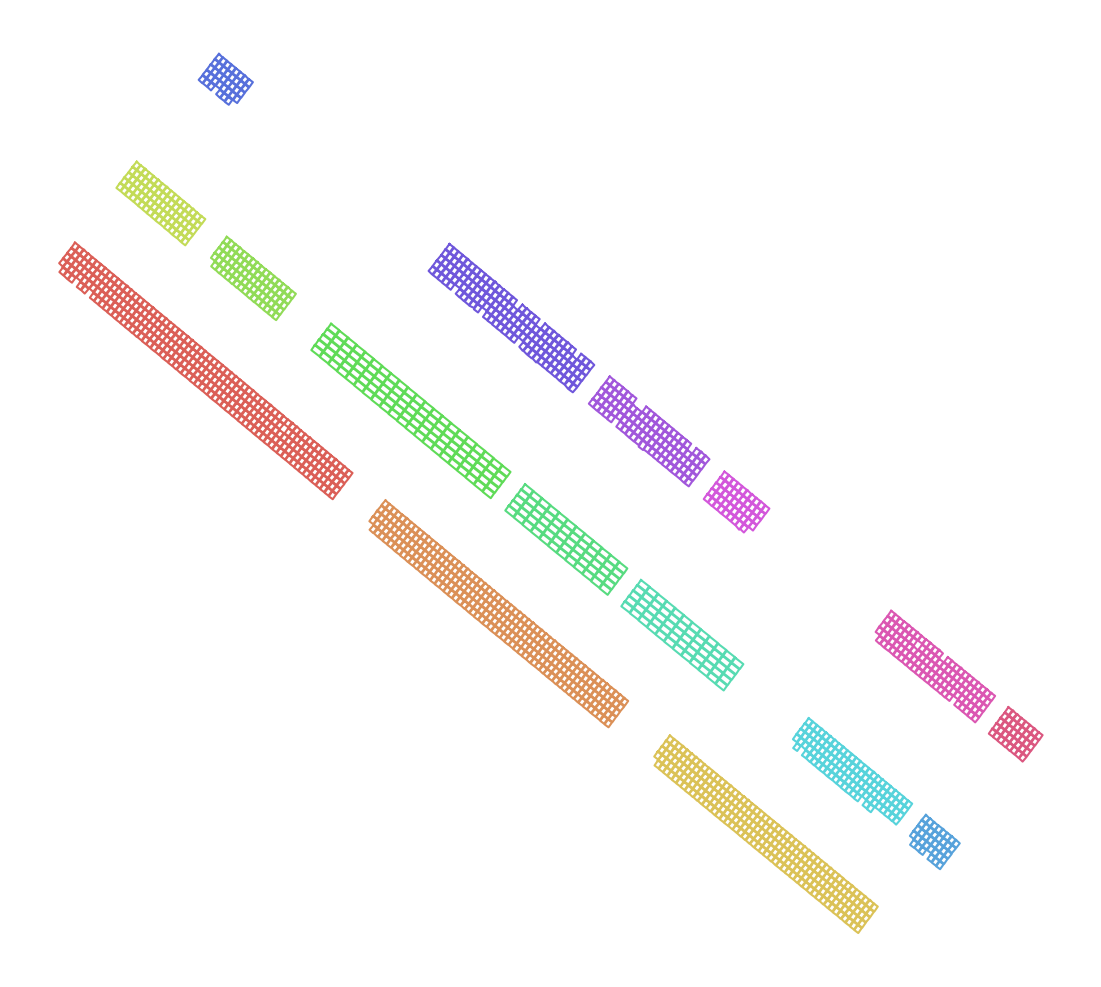

Start 61 64.0
Middle 62 64.0
0.9395724003480385 0.7322621804082305 0.7865657918658321
1.0323176843045074 0.7322621804082305 0.8642077784652885
0.9801297701090927 0.7322621804082305 0.8205185129656453
1.9951173243760914 0.7322621804082305 1.670218322219576
2 3
[ 431649.433438 4182470.104812] [ 431650.736608 4182469.060122] [ 431650.09666626 4182469.50946905] 1.670218322219576 0.7322621804082305 0.10489075381426327
0.9340529184061945 0.7322621804082305 0.7819451413628293
1.0247578105809252 0.7322621804082305 0.8578790079952401
1.9971968044349784 0.7322621804082305 1.6719591650525303
4 5
[ 431651.412964 4182468.532392] [ 431652.709672 4182467.476932] [ 431652.07619226 4182467.93704905] 1.6719591650525303 0.7322621804082305 0.10489075381426327
End 64 64.0
Start 63 64.0
Middle 63 64.0
0.9865089728579209 0.7322621804082305 0.825858881264827
1.0005952460516594 0.7322621804082305 0.8376512462012248
0.9785073288750649 0.7322621804082305 0.8191602815259753
1.026864970088929 0.7322621804082305 0.

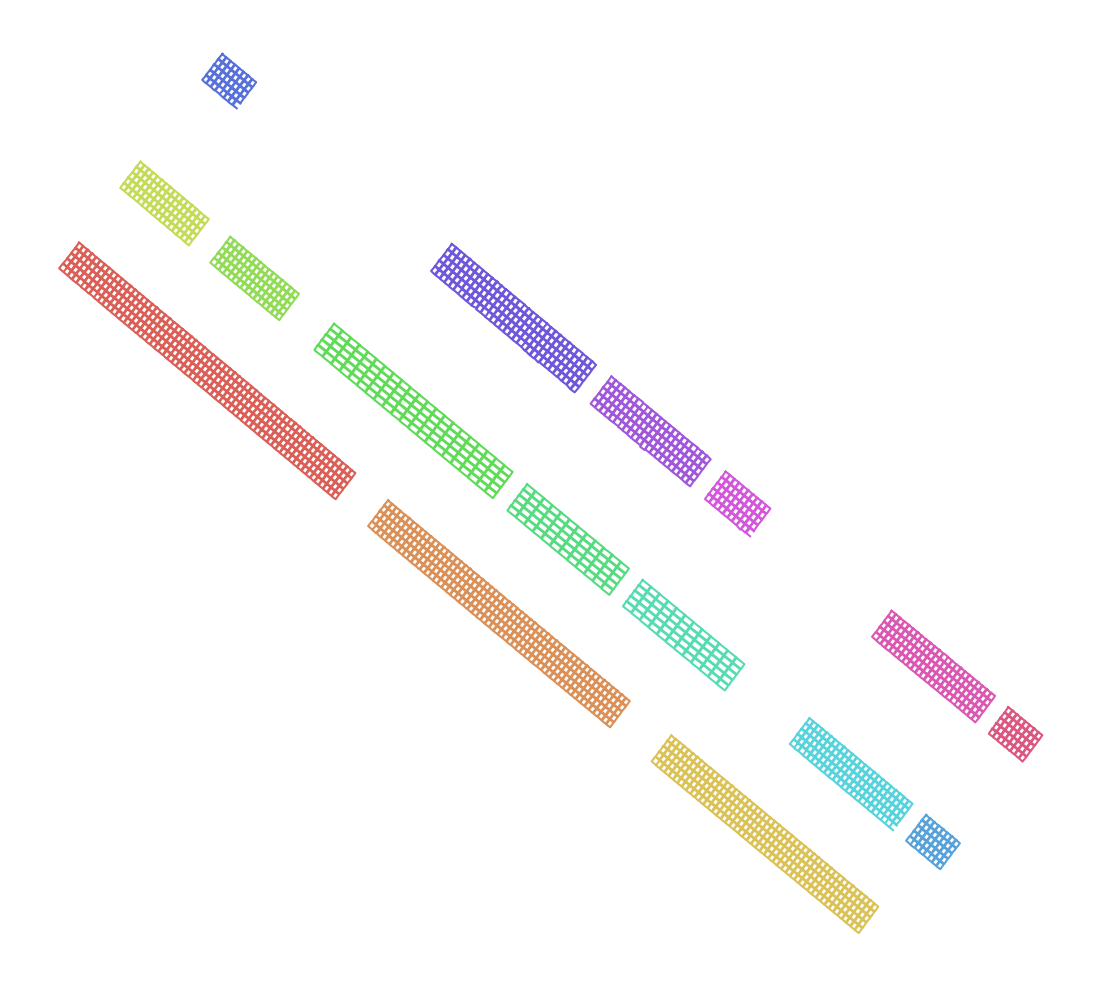

In [20]:
panels, cluster = load_panels(shp)
fill_panels(panels, cluster)

plot_panels([panel for panel in panels], color_code=[panel.id_array for panel in panels], draw_text=False, text=[str(panel.id_array) for panel in panels], draw_legend=False, savefig='results/identified_panels.png', remove_axis=True)

In [21]:
# Write back
schema = shp.schema.copy()
input_crs = shp.crs

with fiona.open(filename.split('.')[0] + '_fixed.shp', 'w', 'ESRI Shapefile', schema, input_crs) as output:
    # for elem in shp:
    #     output.write({'properties': elem['properties'], 'geometry': elem['geometry']})

    for panel in panels:
        if panel.id_array == -1:
            continue

        # Build geometry buffer
        geometry_buffer = [[]]
        for point in panel.geometry:
            geometry_buffer[0].append((point[0], point[1]))

        output.write({'properties': {'No.': -1, 'Area (Ha)': -1, 'Perimetro(': panel.get_perimeter(), 'Area(m2)': panel.get_area(), 'Perimetr_1': panel.get_perimeter(), 'ID_ARRAY': -1, 'ID_CELL': -1, 'ID_ROW': -1, 'ID_COL': -1}, 'geometry': {'type': 'Polygon', 'coordinates': geometry_buffer }})